# Import libraries

In [1]:
# for Kaggle
# !pip install -U lightautoml

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# edited by Mayur

import gc
import scipy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

# Load necessary files

In [3]:
items = pd.read_csv("items.csv.zip")
item_categories = pd.read_csv("item_categories.csv")
sales_train = pd.read_csv("sales_train.csv.zip", parse_dates=['date'])
shops = pd.read_csv("shops.csv")
sales_test = pd.read_csv("test.csv.zip")
submission = pd.read_csv("sample_submission.csv.zip")

# for Kaggle

# PATH = '../input/competitive-data-science-predict-future-sales'

# items           = pd.read_csv(os.path.join(PATH,'items.csv'))
# item_categories = pd.read_csv(os.path.join(PATH,'item_categories.csv'))
# sales_train     = pd.read_csv(os.path.join(PATH,'sales_train.csv'), parse_dates=['date'])
# shops           = pd.read_csv(os.path.join(PATH,'shops.csv'))
# sales_test      = pd.read_csv(os.path.join(PATH,'test.csv'))
# submission      = pd.read_csv(os.path.join(PATH,'sample_submission.csv'))

# Research dataset

In [4]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


Correlation between dataset features

In [5]:
sales_train.join(items.set_index('item_id'), on='item_id').corr()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
date_block_num,1.000000,0.019273,0.009356,0.095010,0.009402,0.029128
shop_id,0.019273,1.000000,0.029396,-0.024034,-0.005230,0.019380
item_id,0.009356,0.029396,1.000000,-0.134104,0.016650,0.369431
item_price,0.095010,-0.024034,-0.134104,1.000000,0.011197,-0.253554
item_cnt_day,0.009402,-0.005230,0.016650,0.011197,1.000000,0.014768
item_category_id,0.029128,0.019380,0.369431,-0.253554,0.014768,1.000000


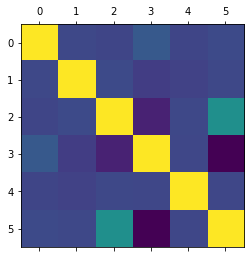

In [6]:
plt.matshow(sales_train.join(items.set_index('item_id'), on='item_id').corr())

Does train dataset contains zeros?

In [7]:
sales_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

Research features

# item_cnt_day

In [8]:
sales_train.item_cnt_day.describe()

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

(array([2.934464e+06, 1.204000e+03, 1.110000e+02, 3.100000e+01,
        1.100000e+01, 5.000000e+00, 4.000000e+00, 4.000000e+00,
        0.000000e+00, 8.000000e+00, 2.000000e+00, 1.000000e+00,
        2.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00]),
 array([ -22.   ,   32.775,   87.55 ,  142.325,  197.1  ,  251.875,
         306.65 ,  361.425,  416.2  ,  470.975,  525.75 ,  580.525,
         635.3  ,  690.075,  744.85 ,  799.625,  854.4  ,  909.175,
         963.95 , 1018.725, 1073.5  , 1128.275, 1183.05 , 1237.825,
        1292.6  , 1347.375, 1402.15 , 1456.925, 1511.7  , 1566.475,
        1621.25 , 

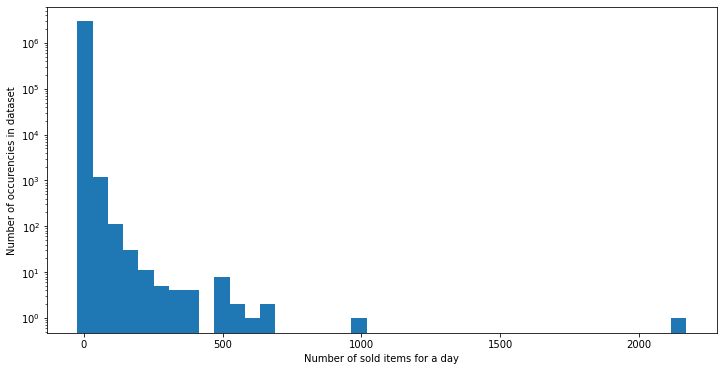

In [9]:
plt.figure(figsize=(12,6))
plt.xlabel('Number of sold items for a day')
plt.ylabel('Number of occurencies in dataset')
plt.yscale('log')
plt.hist(sales_train.item_cnt_day, bins=40)

Group number of sold items by date_block and plot.

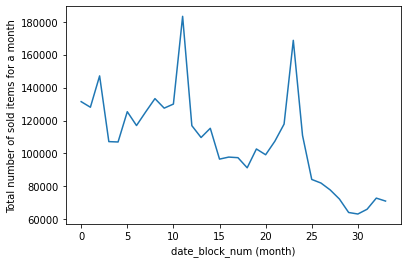

In [10]:
plt.xlabel('date_block_num (month)')
plt.ylabel('Total number of sold items for a month')
plt.plot(sales_train.groupby(['date_block_num']).agg({'item_cnt_day': 'sum'}).reset_index()['item_cnt_day'])

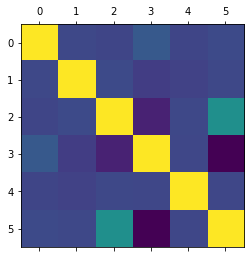

In [11]:
plt.matshow(sales_train.join(items.set_index('item_id'), on='item_id').corr())

There is an obvious trend with peaks at New Year holidays.

# item_price

In [12]:
sales_train.item_price.describe()

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

(array([2.902174e+06, 1.402500e+04, 9.814000e+03, 3.163000e+03,
        4.418000e+03, 2.038000e+03, 1.930000e+02, 1.200000e+01,
        8.000000e+00, 2.000000e+00, 0.000000e+00, 1.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00]),
 array([-1.00000000e+00,  5.13201667e+

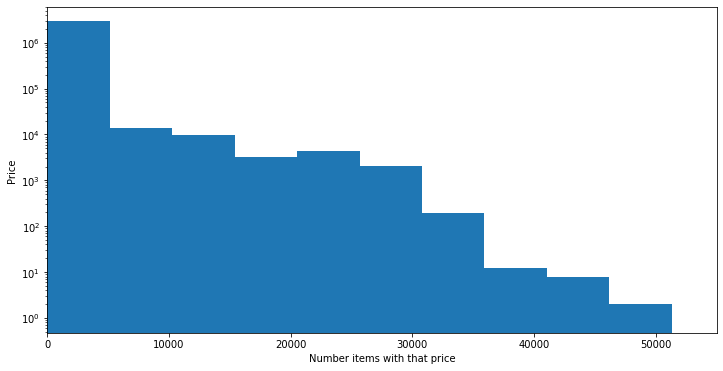

In [13]:
plt.figure(figsize=(12,6))
plt.xlabel('Number items with that price')
plt.xlim(-2, 55000)
plt.ylabel('Price')
plt.yscale('log')
plt.hist(sales_train.item_price, bins=60)

Majority of items has price lower than 5000.

# date_block_num

In [14]:
sales_train.date_block_num.describe()

count    2.935849e+06
mean     1.456991e+01
std      9.422988e+00
min      0.000000e+00
25%      7.000000e+00
50%      1.400000e+01
75%      2.300000e+01
max      3.300000e+01
Name: date_block_num, dtype: float64

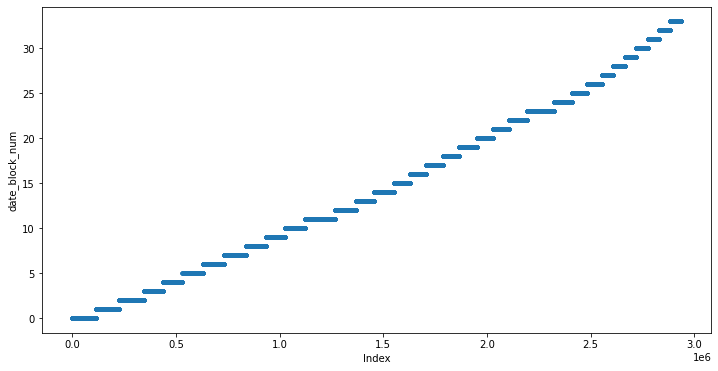

In [15]:
plt.figure(figsize=(12,6))
plt.xlabel('Index')
plt.ylabel('date_block_num')
plt.plot(sales_train.date_block_num, '.')

We can suppose, that dataset was built by concatenating of smaller datasets for each date block

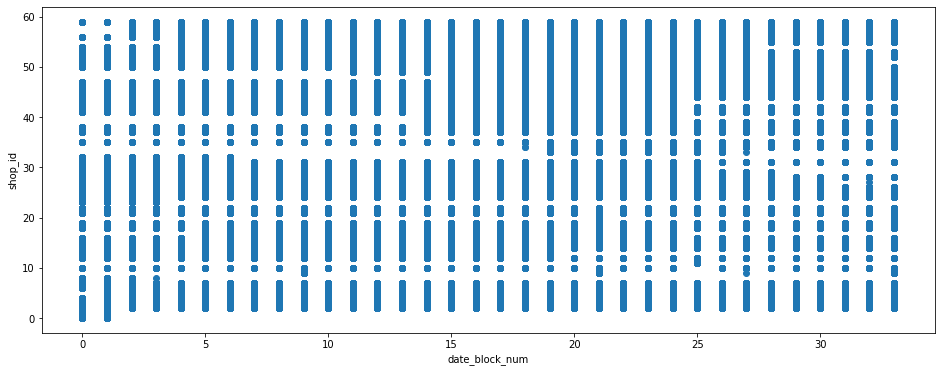

In [16]:
plt.figure(figsize=(16, 6))
plt.xlabel('date_block_num')
plt.ylabel('shop_id')
plt.scatter(sales_train.date_block_num, sales_train.shop_id)

We can see strong vertical pattern. This means that data wasn't shaffled for shops. We also can see, that data for some shops and date blocks are missing.

# Fix item_price feature

Some of prices may be wrong. Let's find them. At first we look for prices with big difference for each item and find for them the most frequent normal prices.

In [17]:
sales_train.duplicated(subset=['date', 'shop_id', 'item_id']).sum()

28

In [18]:
# for each item get price mode which more than 5
def amode(col):
    i = 0
    res = 0
    count = col.value_counts().index
    while res <= 5 and i < len(count):
        res = count[i]
        i += 1
    return res

def alast(col):
    return res
    
# group train dataset by prices, aggregate by price mode
item_prices = sales_train[['item_id', 'item_price']].groupby('item_id').agg({'item_price': [np.min, 
                                                                                            np.max, 
                                                                                            amode]})
# add feature for difference between min and max prices
item_prices['price_diff'] = abs(item_prices.item_price.amax/item_prices.item_price.amin)
# get all prices with the difference between min and max prices more than 15 and min price less than 5
# save indexes of these prices
wrong_prices = item_prices[(item_prices.item_price.amin <= 5) & 
                           (item_prices.price_diff >= 15)].sort_values('price_diff', ascending=False)

wrong_prices.head()

item_price                    price_diff
              amin    amax   amode              
item_id                                         
11865         0.07   729.0   329.0  10414.285714
11857         0.10   729.0   319.0   7290.000000
11864         0.07   469.0   269.0   6700.000000
1836          0.50  2599.0  1999.0   5198.000000
1837          0.50  2599.0  1999.0   5198.000000

Fix wrong prices

In [19]:
for i_id in list(wrong_prices.index):
    sales_train.loc[(sales_train.item_id == i_id) & 
                    (sales_train.item_price <= 5), 'item_price'] = wrong_prices.loc[i_id, 'item_price'].amode
    
shops_last_prices = sales_train[['shop_id', 'item_id', 'item_price']].groupby(['shop_id', 
                                                                               'item_id']).agg('last')

sales_test = sales_test.join(shops_last_prices, on=['shop_id', 'item_id'])
sales_test.drop('ID', axis=1, inplace=True)

Group dataset by shop, item and date number.

# Group train dataset, investigate data distribution for train and test datasets.

In [20]:
#drop date feature, it's erratic
sales_train.drop('date', axis=1, inplace=True)

sales_train_gr = sales_train.groupby(['date_block_num', 
                                      'shop_id', 'item_id'], as_index=False).agg({'item_price': 'mean', 
                                                                                  'item_cnt_day': 'sum'})

sales_train_gr.rename({'item_cnt_day': 'item_cnt_month'}, axis=1, inplace=True)


Let's investigate distribution of items and shops according to mean date block number.

Train dataset.

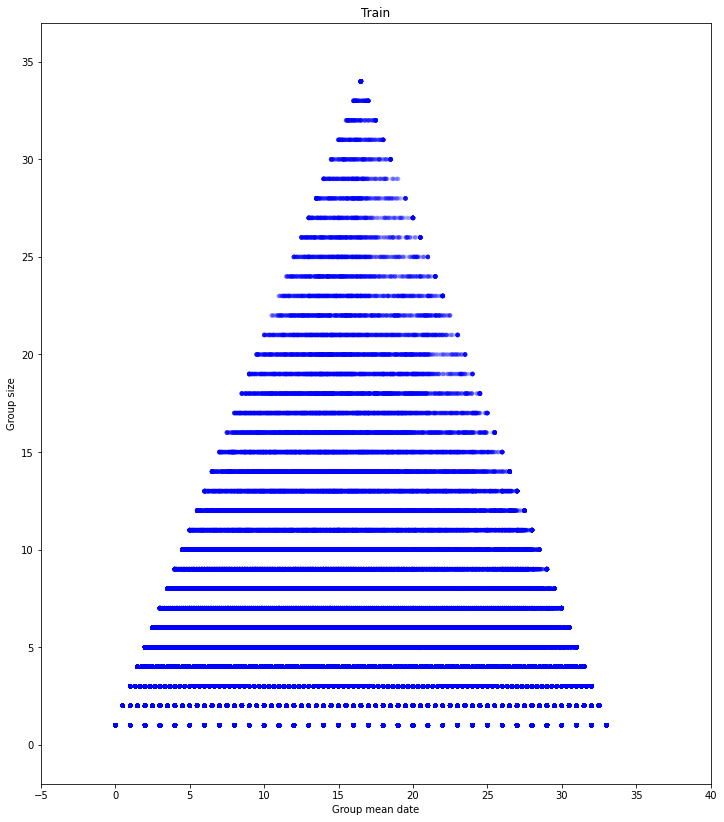

In [21]:
from matplotlib import pyplot as plt

g = sales_train_gr.groupby(['shop_id', 'item_id'])

plt.figure(figsize=(12,14))
plt.scatter(g.date_block_num.mean(), g.size(), edgecolor = 'none', alpha = 0.2, s=20, c='b')
plt.xlabel('Group mean date')
plt.ylabel('Group size')
plt.ylim(-2, 37)
plt.xlim(-5, 40)
plt.title('Train');

Test dataset

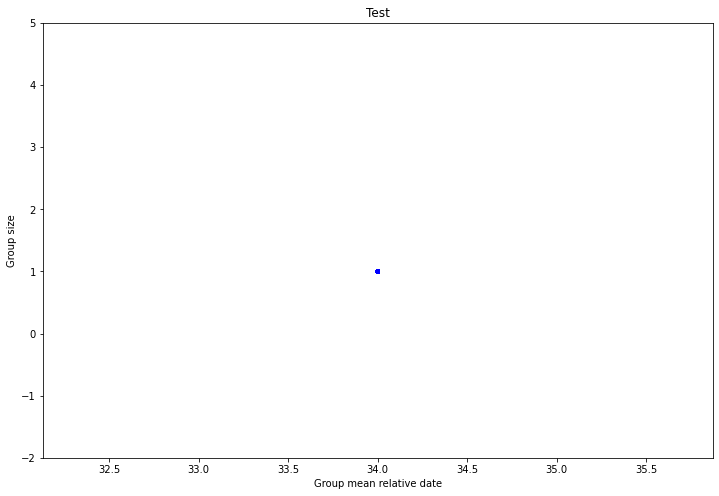

In [22]:
sales_test['date_block_num'] = 34
g = sales_test.groupby(['shop_id', 'item_id'])

plt.figure(figsize=(12,8))
plt.scatter(g.date_block_num.mean(),g.size(),edgecolor = 'none',alpha = 0.2, s=20, c='b')
plt.xlabel('Group mean relative date')
plt.ylabel('Group size')
plt.ylim(-2, 5)
plt.title('Test');

What does that mean? That mean that all groups in test dataset have size of one and labeled by 34th date block num, but that's not surprise for us.

But train dataset has groups with completely different sizes and completely different data. For top groups in top of our triangle we have information about all days, so, that's why their mean date is 16.5. For other groups we don't have full information, that's why their mean date becomes volatile.

Why does this happen? Let's investigate item_cnt_month feature in our dataset. 

In [23]:
sales_train.item_cnt_day.value_counts().sort_index().head(10)

-22.0          1
-16.0          1
-9.0           1
-6.0           2
-5.0           4
-4.0           3
-3.0          14
-2.0          78
-1.0        7252
 1.0     2629372
Name: item_cnt_day, dtype: int64

So, in train dataset we find positive and negative values, but don't find zero. Our train dataset just doesn't include data with item_cnt_day equals to zero. So, we most add this combinations to our dataset and set item_cnt_month value for them to zero.

Add new dataset to train dataset

In [24]:
sales_test_gr1 = sales_test.loc[~sales_test.item_id.isin(sales_train_gr.item_id)].copy()
sales_test_gr1.loc[:, 'item_cnt_month'] = 0

# uncomment, if you want to add test set
# sales_train_gr = pd.concat([sales_train_gr, sales_test_gr1]).sort_values(['shop_id', 
#                                                                           'item_id']).reset_index(drop=True)
# sales_train_gr.loc[sales_train_gr.date_block_num == 34, 'date_block_num'] = 33

In [25]:
# add all possible combinations for existing shop_id/item_id pair and date_block_num
sales_train_gr1 = sales_train_gr.groupby(['shop_id', 
                                          'item_id']).agg('max').reset_index()

sales_train_gr1 = sales_train_gr1.set_index(['shop_id', 
                                             'item_id', 
                                             'date_block_num']).unstack().stack(dropna=False).reset_index()

# fill NaN values of item_cnt_month feature with zeros
sales_train_gr1.item_cnt_month.fillna(0, inplace=True)

In [26]:
sales_train_gr2 = pd.concat([sales_train_gr, 
                             sales_train_gr1[sales_train_gr1.item_price.isnull()]]).sort_values(['date_block_num', 
                                                                                                 'shop_id', 
                                                                                                 'item_id']).reset_index(drop=True)

sales_train_gr2.drop_duplicates(subset = ['date_block_num', 'shop_id', 'item_id'], inplace=True)
sales_train_gr2.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_month
0,0,0,30,NaN,0.0
1,0,0,31,NaN,0.0
2,0,0,32,221.0,6.0
4,0,0,33,347.0,3.0
6,0,0,35,247.0,1.0


Distribution of items for each shop

<AxesSubplot:xlabel='shop_id'>

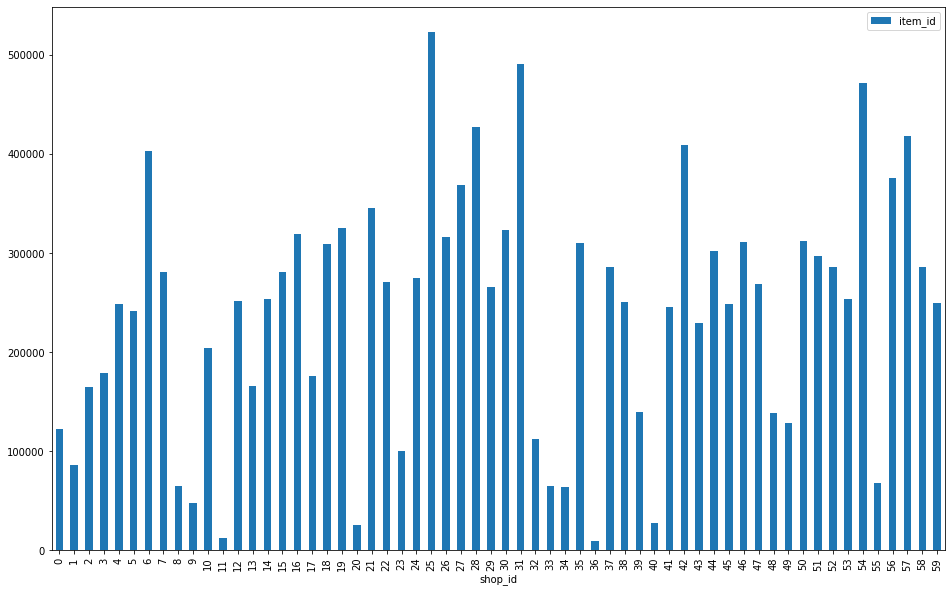

In [27]:
sales_train_gr2.groupby('shop_id').agg({'item_id': 'count'}).plot.bar(figsize=(16, 10))

# Add data from files to train and test datasets

Train dataset

In [28]:
sales_train2 = sales_train_gr2.join(items.set_index('item_id'), on='item_id')
sales_train2 = sales_train2.join(item_categories.set_index('item_category_id'), on='item_category_id')
sales_train2 = sales_train2.join(shops.set_index('shop_id'), on='shop_id')

sales_train2.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_month,item_name,item_category_id,item_category_name,shop_name
0,0,0,30,NaN,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
1,0,0,31,NaN,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),37,Кино - Blu-Ray,"!Якутск Орджоникидзе, 56 фран"
2,0,0,32,221.0,6.0,1+1,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
4,0,0,33,347.0,3.0,1+1 (BD),37,Кино - Blu-Ray,"!Якутск Орджоникидзе, 56 фран"
6,0,0,35,247.0,1.0,10 ЛЕТ СПУСТЯ,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"


Test dataset

In [29]:
sales_test2 = sales_test.join(items.set_index('item_id'), on='item_id')
sales_test2 = sales_test2.join(item_categories.set_index('item_category_id'), on='item_category_id')
sales_test2 = sales_test2.join(shops.set_index('shop_id'), on='shop_id')

sales_test2.head()

,shop_id,item_id,item_price,date_block_num,item_name,item_category_id,item_category_name,shop_name
0,5,5037,749.5,34,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад"""
1,5,5320,NaN,34,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад"""
2,5,5233,1199.0,34,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад"""
3,5,5232,599.0,34,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"Вологда ТРЦ ""Мармелад"""
4,5,5268,NaN,34,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"Вологда ТРЦ ""Мармелад"""


Clear memory

In [30]:
del sales_train, sales_train_gr, sales_train_gr1, sales_train_gr2, sales_test
del shops_last_prices, item_prices, wrong_prices
gc.collect()

92

Add expert features

In [31]:
def add_month(col):
    return int(divmod(col, 12)[1] + 1)

def add_year(col):
    return int(2013 + divmod(col+1, 12)[0])

def add_city(col):
    city = col.split(' ')
    if city[0][0] == '!':
        return city[0][1:]
    if city[0] == 'Цифровой':
        return 'Цифровой склад'
    if city[0] == 'Выездная':
        return 'Выездная Торговля'
    return city[0]

def add_season(col):
    if 0 < col <= 2 or col == 12:
        return 'winter'
    if 3 <= col < 6:
        return 'spring'
    if 6 <= col < 9:
        return 'summer'
    if 9 <= col < 12:
        return 'autumn'
    return np.nan

def add_holidays(col):
    if np.isnan(col):
        -1
    if col == 1 or col == 5:
        return 1
    return 0

def add_int_part(col):
    if np.isnan(col):
        return np.nan
    return divmod(col, 100)[0]

def add_fract_part(col):
    if np.isnan(col):
        return np.nan
    return divmod(col, 100)[1]

def add_global_category(col):
    cat = col.split(' ')
    if cat[0] == 'Игровые':
        return 'Игровые консоли'
    if cat[0] == 'Карты':
        return 'Карты оплаты'
    if cat[0] == 'Чистые':
        return 'Чистые носители'
    if cat[0] == 'Элементы':
        return 'Элементы питания'
    if cat[0] == 'Доставка':
        return 'Доставка товара'
    return cat[0]

# define if item is material thing
def is_material(col):
    material_list = ['Развитие', 'Аксессуары', 'Гаджеты', 'консоли', 'Открытки', 'Cувениры', 
                     'Настольные игры', 'Мягкие игрушки', 'Гарнитуры', 'Элементы','Комиксы',
                     'Фигурки', 'Атрибутика', 'Сумки', 'литература', 'Путеводители', 'Артбуки']
    for i in material_list:
        if i in col:
            return 1
    return 0
        
 # define if item is service
def is_service(col):
    service_list = ['Доставка товара', 'Служебные', 'Подарки - Сертификаты, услуги']
    if col in service_list:
        return 1
    return 0   
    
month_dict = {1: 31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}

    
def create_expert_features(data):
    # add expert features
    data['price_int'] = data.item_price.apply(add_int_part) 
    data['price_fract'] = data.item_price.apply(add_fract_part) 
    data['month'] = data.date_block_num.apply(add_month) 
    data['year'] = data.date_block_num.apply(add_year) 
    data['city'] = data.shop_name.apply(add_city) 
    data['season'] = data.month.apply(add_season) 
    data['global_category'] = data.item_category_name.apply(add_global_category)
#     data['has_holidays'] = data.month.apply(add_holidays) 
#     data['is_material'] = data.item_category_name.apply(is_material)
#     data['is_service'] = data.item_category_name.apply(is_service)
    # add number of days in each month
    data['days_in_month'] = np.nan
    for m in month_dict.keys():
        data.loc[data.month == m, 'days_in_month'] = month_dict[m]

Additional features

In [32]:
def create_time_features():
    global sales_train2, sales_test2
    for feat in ['item_cnt_month']:
        win = [i for i in range(1, 13)]
        for w in win:
            tmp = sales_train2[['date_block_num', 'shop_id', 'item_id', feat]].copy()
            tmp.date_block_num = tmp.date_block_num + w
            tmp.rename({feat: feat + str(w)}, axis=1, inplace=True)

            sales_train2 = sales_train2.join(tmp.set_index(['date_block_num', 'shop_id', 'item_id']), 
                                             on=['date_block_num', 'shop_id', 'item_id'])
            sales_test2 = sales_test2.join(tmp.set_index(['date_block_num', 'shop_id', 'item_id']), 
                                           on=['date_block_num', 'shop_id', 'item_id'])
            del tmp
            gc.collect()
            
def get_window(data, w):
    cols = []
    col_num = 1
    for i in data.columns:
        if col_num > w:
            break
        if i == f'item_cnt_month{col_num}':
            cols.append(i)
            col_num += 1
    return cols
            
def create_time_statistics(data):
    for win in [2, 3, 6, 12]:
        cols = get_window(data, win)
        tmp = data[cols]
        
        data[f'{win}_month_mean_cnt'] = tmp.mean(axis=1)
        data[f'{win}_month_median_cnt'] = tmp.median(axis=1)
        data[f'{win}_month_min_cnt'] = np.nanmin(tmp, axis=1)
        data[f'{win}_month_max_cnt'] = np.nanmax(tmp, axis=1)
        data[f'{win}_month_std_cnt'] = tmp.std(axis=1)
            

def create_col_with_min_freq(data, col, min_freq=10):
    # replace rare values (less than min_freq rows) in feature by RARE_VALUE
    data[col + '_fixed'] = data[col].astype(str)
    data.loc[sales_train2[col].value_counts()[data[col + '_fixed']].values < min_freq, col + 
             '_fixed'] = "RARE_VALUE"

            
def create_gr_feats(data):
    # create aggregation feats for numeric features based on categorical ones
    for cat_col in ['shop_id', 'item_category_id', 'city', 'global_category', 'item_id']:
#         create_col_with_min_freq(data, cat_col, 15,)
        for num_col in ['item_price']:
            for n, f in [('mean', np.mean), ('min', np.nanmin), ('max', np.nanmax)]:
                data[n + '_' + num_col + '_by_' + cat_col] = sales_train2.groupby(cat_col)[num_col].transform(f)
                
    # create features with counts
    for col in ['shop_id', 'item_id', 'item_category_id', 'city', 'global_category', 'item_price']:
        data[col + '_cnt'] = data[col].map(sales_train2[col].value_counts(dropna = False))

Add expert features

In [33]:
%%time

create_expert_features(sales_train2)
create_expert_features(sales_test2)

# create_gr_feats(sales_train2)
# create_gr_feats(sales_test2)

# # some values of item_name feature in test dataset can't be met in train dataset
# # so we need to add them in values_count for test dataset to prevent error
# train_vc = pd.concat([sales_train2['item_name_fixed'].value_counts(), 
#            sales_test2.loc[~sales_test2['item_name_fixed'].isin(sales_train2['item_name_fixed']), 
#                           'item_name_fixed'].value_counts()])
# train_vc[len(sales_train2['item_name_fixed'].value_counts()):] = 0

# sales_test2.loc[train_vc[sales_test2['item_name_fixed']].values < 15, 'item_name_fixed'] = 'RARE_VALUE'

CPU times: user 45.1 s, sys: 2.02 s, total: 47.2 s
Wall time: 47.1 s


Drop unnecessary columns

In [34]:
sales_train2.drop(['shop_name', 'item_name', 'item_category_name'], axis=1, inplace=True)
sales_test2.drop(['shop_name', 'item_name', 'item_category_name'], axis=1, inplace=True)

Encode text features with label encoder.

In [35]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

cols = ['city', 'season', 'global_category']
sales_train2[cols] = sales_train2[cols].apply(LabelEncoder().fit_transform)
sales_test2[cols] = sales_test2[cols].apply(LabelEncoder().fit_transform)

Add time features

In [ ]:
%%time

create_time_features()

cols = [c for c in sales_train2.columns if 'item_cnt_month' in c and c != 'item_cnt_month']

sales_train2[cols].fillna(0, inplace=True)
sales_test2[cols].fillna(0, inplace=True)

create_time_statistics(sales_train2)
create_time_statistics(sales_test2)

In [ ]:
sales_train2.head()

In [ ]:
# sales_train2.date_block_num.fillna(-1, inplace=True)
# sales_train2.month.fillna(-1, inplace=True)
# sales_train2.year.fillna(-1, inplace=True)
# sales_train2.days_in_month.fillna(-1, inplace=True)

# sales_train2.date_block_num = sales_train2.date_block_num.astype('int')
# sales_train2.month = sales_train2.month.astype('int')
# sales_train2.year = sales_train2.year.astype('int')
# sales_train2.days_in_month = sales_train2.days_in_month.astype('int')
# sales_train2.item_cnt_month = sales_train2.item_cnt_month.astype('int')

# sales_test2.days_in_month = sales_test2.days_in_month.astype('int')

In [ ]:
sales_train2.isnull().sum()

In [ ]:
sales_test2.isnull().sum()

In [ ]:
sales_train2.head()

In [ ]:
sales_test2.head()

# Use Light GBM to predict sales

Split datasets by train and validation parts, make them sparse

In [ ]:
sales_train2

In [ ]:
cols = [col for col in sales_train2.columns if col not in ['item_cnt_month']]

x = sales_train2[cols]
y = sales_train2['item_cnt_month']

train_index = x[(x.date_block_num < 33)].index
valid_index = x[x.date_block_num == 33].index

X_train, X_valid = x.loc[train_index], x.loc[valid_index]

del x
gc.collect()

# X_train = scipy.sparse.csr_matrix(X_train.values)
# X_valid = scipy.sparse.csr_matrix(X_valid.values)

y_train, y_valid = y.loc[train_index], y.loc[valid_index]

In [ ]:
# parameters = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'boosting': 'gbdt',
#     'num_leaves': 64,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.9,
#     'bagging_freq': 20,
#     'learning_rate': 0.06,
#     'verbose': -1,
#     'random_state': 42,
# }

Use time split series for LGBM

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

y_preds = np.zeros(sales_test2.shape[0])

feature_importances = pd.DataFrame()
feature_importances['feature'] = sales_test2.columns
mean_score = []

cat_feats = ['shop_id', 'item_id', 'item_category_id', 'city', 'global_category']

# dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_feats)
# dvalid = lgb.Dataset(X_valid, label=y_valid)

lgb_model = lgb.LGBMRegressor(max_depth=-1,
                              n_estimators=30000,
                              learning_rate=0.05,
                              num_leaves=64,
                              colsample_bytree=0.7,
                              objective='regression', 
                              n_jobs=-1)

lgb_model.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_valid, y_valid)], 
              verbose=100, early_stopping_rounds=100, categorical_feature=cat_feats)

feature_importances['1'] = lgb_model.feature_importances_

y_pred_valid = lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration_)

val_score = mean_squared_error(y_pred_valid, y_valid, squared=False)
print(f'val rmse score is {val_score}')

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.25999	valid_0's l2: 10.6275
[200]	valid_0's rmse: 3.24935	valid_0's l2: 10.5583
Early stopping, best iteration is:
[146]	valid_0's rmse: 3.23644	valid_0's l2: 10.4746
val rmse score is 3.2364431906220275

Features importance

In [ ]:
plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='1', ascending=False), x='1', y='feature');
plt.title('Feature importances');

# Make prediction

In [ ]:
# y = clf.predict(sales_test2, num_iteration=clf.best_iteration)

# submission['item_cnt_month'] = y
# submission.head()

# Save to file

In [ ]:
# submission.to_csv('submission.csv', index=False)

# Futher ideas

- drop duplicates

- try TabularAutoML

- replace nan values with -1

- split dataset according to most important feature(s)
